# 数据增强

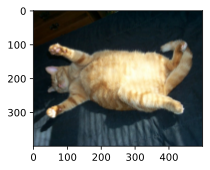

In [1]:
%matplotlib inline
import torch
#用pytorch的这个库来实现可视化
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('D:\chrome_file_download\d2l-zh (1)\mxnet\img/cat1.jpg')
d2l.plt.imshow(img);

## 自定义数据增强

In [9]:
#num_rows=2,num_cols=4是指增强后的图片以2行4列排，相当于把aug作用在img上8次，scale=1.5是指画出来的尺寸大小
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

## 左右翻转

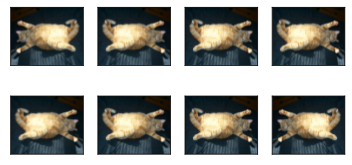

In [10]:
#左右翻转图像 一半的概率
apply(img,torchvision.transforms.RandomHorizontalFlip())

## 上下翻转

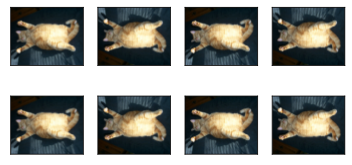

In [11]:
#上下翻转 一半的概率
apply(img, torchvision.transforms.RandomVerticalFlip())

## 随机裁剪

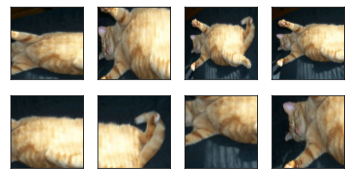

In [17]:
#随机裁剪
#(200, 200)裁剪完之后恢复图像到多大， scale=(0.1, 1)保留原始图像的比例，随机选取一个数，ratio=(0.5, 2)是高宽比，随机取自0.5~2
#scale和ratio的值越靠近1的话，这个增广也就越弱。
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

## 随机更改图像亮度

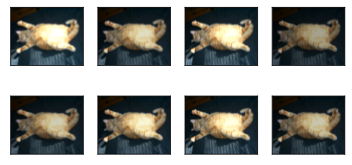

In [13]:
#brightness亮度，contrast对比度，saturation饱和度，hue色温
#brightness=0.5是指上下百分之五十，增加百分之五十或者降低百分之五十
apply(img,torchvision.transforms.ColorJitter(brightness=0.5, contrast=0,saturation=0, hue=0))

## 随机更改图像色调

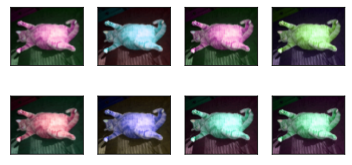

In [18]:
apply(img,torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0,hue=0.5))

## 随机更改图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）

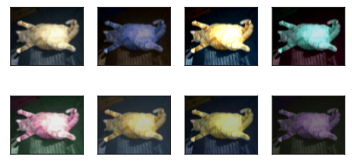

In [15]:
#这个比较常见，大家一起来改
#这个增广的幅度比较大，可能现实中也不会有那么奇怪
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5,saturation=0.5, hue=0.5)
apply(img, color_aug)

## 结合多种图像增广方法

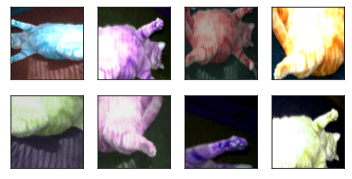

In [19]:
#这是实际情况中最常用的三种方法
augs=torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), 
                                     color_aug, 
                                     shape_aug])
apply(img,augs)

## 使用图像增广进行训练

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data\cifar-10-python.tar.gz to ../data


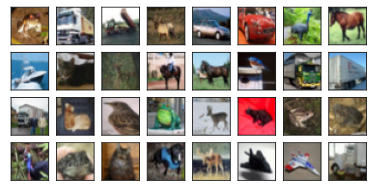

In [20]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

## 只使用最简单的随机左右翻转训练

In [21]:
#因为这个数据集已经在中间了，所以没用resize
#训练集和测试集还挺像的，不要做太狠的增广
#ToTensor把图像变成一个4D的tensor,用来训练。
#使用数据增广和不适用数据增广的主要区别在这里
train_augs=torchvision.transformers.Compose([
   torchvision.transformers.RandomHorizontalFlip(),
   torchvision.transformers.ToTensor()])

test_augs=torchvision.transformers.Compose([
   torchvision.transformers.ToTensor()])

AttributeError: module 'torchvision' has no attribute 'transformers'

## 定义一个辅助函数，以便应用图像增广

In [ ]:
#如果做了很多数据增强，那需要多开几个num_workers,因为做数据增强也是一个很贵的事情，计算量不小，要一个个做augs，要做很多次python的call,多开几个进程，会快一点的。
def load_cifar10(is_train,augs,batch_size):
    #构建一个新的数据集。下载的时候就做数据增强。
    dataset=torchvisio.datasets.CIFAR10(root="../data",train=is_train,transform=augs,download=True)
    dataloader=torch.utils.data.Dataloader(dataset,batch_size=batch_size,shuffle=is_train,num_workers=0)
    return dataloader

In [ ]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    #用多GPU训练
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [ ]:
#现在，我们可以定义train_with_data_aug函数，使用图像增广来训练模型。该函数获取所有的GPU，
#并使用Adam作为训练的优化算法，将图像增广应用于训练集，最后调用刚刚定义的用于训练和评估模型的train_ch13函数。
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    #优化器
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

In [ ]:
#训练模型，使用数据增广
train_with_data_aug(train_augs, test_augs, net)

## 答疑

- 稍微有点过拟合，可以采取更多的数据增强或者weight_decay
- 理论上假设图片很多，不需要做增广，实际上这个情况很难。图片多不代表图片的多样性好。如果图片能覆盖到所有测试的情况，那是OK。
- num_worker根据GPU性能决定
- 测试集上的增广一般是，在正中间，按照短边裁剪一个正方形。或者随机裁剪，每个角落都裁剪出来一个正方形，然后预测，做一个平均。
- 没有固定随机种子，这样每次结果都不一样。
- 随着训练的增加，gap不会减少，一般都是会继续增加。因为神经网络的训练总是会过拟合。
- 数据增广之后，图像不需要一张张确认，只需要看几张，不那么奇怪就行。
- 训练数据的分布并没有改变，只是多样性增加了。增广没有改变均值，但是方差变大了。
- 神经网路不是认猫，是认猫的不同部位，比如纹理，爪子
- mixup是把两张图像拼接， label也需要做拼接。非常有用。跟图片的鬼影一样，具体为什么work不知道，但是效果挺好。
- 如果预测结果不好，之前我就直接仍了，把他重新标一下，扔到数据集里，迭代几次就差不多了。
- 增广确实是想让训练集长的像测试集。
- 
